## Overview:

This project builds a model to predict how much someone will pay for a house in King County Seatle, Washington. Inital exploratory data analysis shows that [something]. Based on that discovery, the model used [these initial features] to determine house prices based on unseen data. After [number] iterations, the final model has an R-Squared of [number] and RMSE of [number]. The final model's predictions on the holdout set can be found in [housing_preds_sidney_kung.csv]

## Business Questions:
I will be investigating three main questions through exploratory data anaylsis

1. Do houses sell for more money when they have more interior sqft space?
2. On average, what is the most profitable month to sell a house?
3. Do houses with higher proprty size sell for more?

In [76]:
# importing the neceessary packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from scipy.stats import pearsonr, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import pickle

## Reading in `kc_house_data_train.csv`

In [77]:
# loading in the csv and setting the dataframe to the variable name 'housing'
housing = pd.read_csv('kc_house_data_train.csv')
# checking the unedited training set
housing.head()

Unnamed: 0          id             date      price  bedrooms  bathrooms  \
0           0  2591820310  20141006T000000   365000.0         4       2.25   
1           1  7974200820  20140821T000000   865000.0         5       3.00   
2           2  7701450110  20140815T000000  1038000.0         4       2.50   
3           3  9522300010  20150331T000000  1490000.0         3       3.50   
4           4  9510861140  20140714T000000   711000.0         3       2.50   

   sqft_living  sqft_lot  floors  waterfront  view  condition  grade  \
0         2070      8893     2.0           0     0          4      8   
1         2900      6730     1.0           0     0          5      8   
2         3770     10893     2.0           0     2          3     11   
3         4560     14608     2.0           0     2          3     12   
4         2550      5376     2.0           0     0          3      9   

   sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0        2070              0      1986             0    98058  47.4388   
1        1830           1070      1977             0    98115  47.6784   
2        3770              0      1997             0    98006  47.5646   
3        4560              0      1990             0    98034  47.6995   
4        2550              0      2004             0    98052  47.6647   

      long  sqft_living15  sqft_lot15  
0 -122.162           2390        7700  
1 -122.285           2370        6283  
2 -122.129           3710        9685  
3 -122.228           4050       14226  
4 -122.083           2250        4050

## Data Cleaning & EDA

In this section, I will be iterively cleaning data (dealing with extreme values) and creating visualizations to become more familiar with the data. 

Our dataset from `kc_house_data_train.csv` does not have any null values, so we are safe to proceed onto iteravely cleaning data with exploratory data analysis (EDA).
    
- This was confirmed by running `housing.isna().sum()`

In [78]:
# removing this column because it's just indexing the houses
# using inplace = True because i want to permanently delete the column

housing.drop('Unnamed: 0', axis=1, inplace=True)

In [79]:
# some values in the 'bedrooms' & 'bathrooms' columns are listed as 0, I'm going to repalce them with the column's median.
# it's illegal to have 0 bedrooms or bathrooms in a house, so it's safe to assume that the 0's are mistakes (mising data, but non NaN) 

housing['bedrooms'].replace(0, housing.bedrooms.median(), inplace = True)
housing['bathrooms'].replace(0, housing.bathrooms.median(), inplace = True)

# there is also a house with 33 bedrooms, which was confirmed to be false.
# so if any entry has over 20 bedroms, then replace it with the median.

housing.loc[housing.bedrooms > 20, 'bedrooms'] = housing.bedrooms.median()

### Assumption of Linearity:
A key assumption of lienar regression is that the relationship between X and Y is ***linear***. Let's check the relationship between `sqft_living` and `price`, to see if that feature should be included in the model. I'll visualize this with a pairplot, because it provides the distribution for each variable, as well.

<Figure size 1008x1440 with 0 Axes>

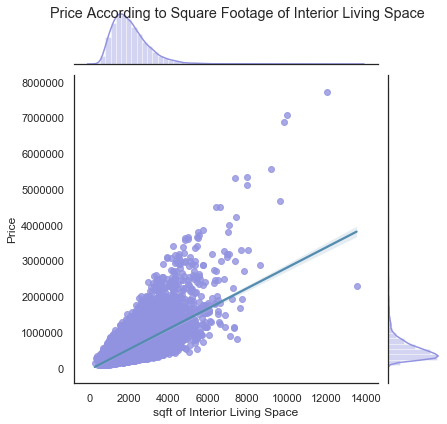

In [80]:
sns.set(style="white", color_codes=True)

sqft = plt.figure(figsize=(14,20))
sqft = sns.jointplot(data = housing, x='sqft_living', y='price', kind='reg', color='#9293E0', joint_kws={'line_kws':{'color':'#548CAF'}})

sqft.fig.suptitle('Price According to Square Footage of Interior Living Space')
plt.xlabel('sqft of Interior Living Space')
plt.ylabel('Price')

plt.savefig('visualizations/sqft_living.png', bbox_inches = "tight", pad_inches=.5)

It looks like the varibles 'sqft_living' and 'price' have a highly positive correlation.

Let's confirm this by running a statstical test. We can use Pearson's Correlation Coefficient because these are two continuous variables.


In [81]:
corr = pearsonr(housing.sqft_living, housing.price)
corr

(0.7035403039789669, 0.0)

- The correlation between `sqft_lviing` and `price` is slightly above 0.7. 
- A correlation coefficient above 0.7 is considered strong, meaning that it's safe to use that feature in our model because it's stastically signifigant.

## Feature Engineering

Based on the data that we were given in `kc_house_data_train.csv`, I will be generating new features that could be helpful for the final model's predictions. With each new feature, I'll perform brief EDA to visualize that new feature.

### New Feature #1: Pulling the month from the 'date' column
The purpose is to see if there is any relationship between price and the months that each house is sold.

In [82]:
# cleaning the dates column, so that it's only the date numbers
housing["date"] = housing["date"].str.replace('T000000', '')

# make new column called month_sold with only the months
housing['month_sold'] = housing['date'].str[4:6]

# removing 0s only if they are at the begnining of single digit months
housing['month_sold'] = housing['month_sold'].str.replace('01', '1').replace('02', '2').replace('03', '3').replace('04', '4').replace('05', '5').replace('06', '6').replace('07', '7').replace('08', '8').replace('09', '9')

# converting new column 'month_sold' to int so we can graph it
housing['month_sold'] = housing['month_sold'].astype(int)

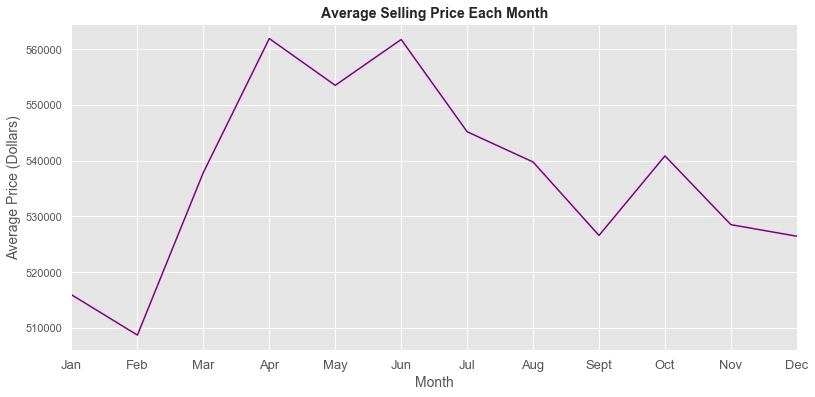

<Figure size 432x288 with 0 Axes>

In [83]:
# creating a graph of average price per month to visualize if there's a trend

housing.sort_values(by='month_sold', ascending=True)
months = sorted(housing['month_sold'].unique())

avg_price = housing.groupby('month_sold')['price'].mean()

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(13,6))
ax.plot(months, avg_price, color='purple')

# setting title and axis labels
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Average Price (Dollars)', fontsize=14)
ax.set_title('Average Selling Price Each Month', fontsize=14, weight='bold')

# setting month labels
ax.set_xlim(1, 12)
ax.set_xticks((1,2,3,4,5,6,7,8,9,10,11,12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'], fontsize=13)

plt.show()

# this graph shows the average price for each month for visualization purposes
# but if i use this feature in the model, we wouldn't find the average each month. just keep it as is to account for each individual house

plt.savefig('visualizations/month_sold.png', bbox_inches = "tight", pad_inches=.5)

From this graph, it's clear that houses are the least profitable on average in February. Meanwhile, it's on average the most profitable to sell a house in April to June.

### Running an ANOVA test on `price` and `month_sold`

The purpose of an ANOVA test is to test how various independent factors may influence the overall result. In this sitiation, we would want to test how each month influences the prices that houses are typically sold at.

The general idea is to break the sum of squared deviations into multiple parts: the sum of squared deviations of the mean of each of the test groups to the observations within the group itself, and the sum of squared deviations of the mean of these test groups to the mean of all observations. 

Luckily, we can easily do this with `scipy`!

- **Null Hypothesis:** There is no difference in means for each month's sample
- **Alternative Hypothesis:** The means are not equal for each month's sample
- **Signifigance Level (alpha):** 0.05

In [84]:
# creating a sample measurement for each month, using the month value as the first argument, and price as the continuous variable
jan = housing.loc[housing['month_sold'] == 1, 'price']
feb = housing.loc[housing['month_sold'] == 2, 'price']
mar = housing.loc[housing['month_sold'] == 3, 'price']
apr = housing.loc[housing['month_sold'] == 4, 'price']
may = housing.loc[housing['month_sold'] == 5, 'price']
jun = housing.loc[housing['month_sold'] == 6, 'price']
jul = housing.loc[housing['month_sold'] == 7, 'price']
aug = housing.loc[housing['month_sold'] == 8, 'price']
sep = housing.loc[housing['month_sold'] == 9, 'price']
otb = housing.loc[housing['month_sold'] == 10, 'price']
nov = housing.loc[housing['month_sold'] == 11, 'price']
dec = housing.loc[housing['month_sold'] == 12, 'price']

# using scipy function f_oneway to conduct an ANOVA test for the f-statistic
sp.stats.f_oneway(jan,feb,mar,apr,may,jun,jul,aug,sep,otb,nov,dec)

F_onewayResult(statistic=2.7046975005044085, pvalue=0.0017444151469153434)

According to the output:
- f-statstic: 2.7051826530074017
- p-value: 0.0017410682855530015

The f-statistic represents the variation between each sample, which are the months in this case. Variances measure the dispersion of the data points around the mean. The higher the f-value, the farther that indivudal data points tend to fall from the mean.

Because the p-value is way below 0.5, we can safely reject the null hypothesis.

Therefore, in this situation, the f-value describes that the variance between the mean price for each month is pretty high. And we can safely use the p-value to reject the null hypothesis, and say that each month sees different selling prices for each house.

In terms of building the model, this information is valuable because it proves that the month greatly impacts how much a house could sell for.

### New Feature #2: Total sqft of the property

In the given data set, the entire property size is split up between 'sqft_living' and 'sqft_lot' so I want to add those together so see if there's any signifigance.

In [85]:
housing['full_sqft'] = housing['sqft_living'] + housing['sqft_lot']

In [86]:
# creating new column with full proprty size
housing['full_sqft'] = housing['sqft_living'] + housing['sqft_lot']

# when i graphed this new 'full_sqft' column, there was an outlier and i decided to repalce with the median.
# i tried playing around with proportions to the 75th percentile, but there was way too much data outside of that scope
# so eventhough it may impact reproducability, I'm gonna manually set the threshold here.

housing.loc[housing.full_sqft > 1400000] = housing.full_sqft.median()

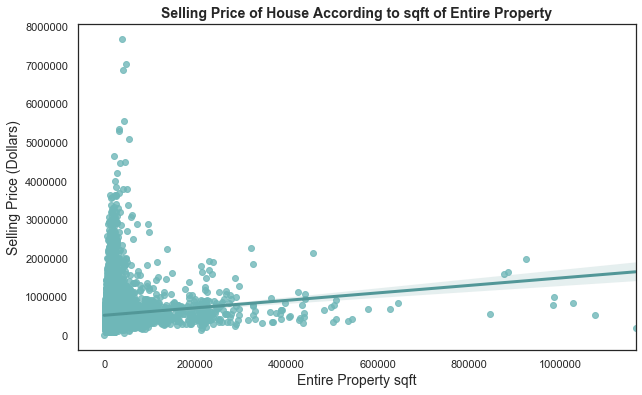

In [119]:
# creating plot
fig, ax = plt.subplots(figsize=(10,6))
plt.style.use('bmh')
sns.regplot(data=housing, x='full_sqft', y='price', scatter_kws={"color": '#6FB7B8'}, line_kws={"color": '#529798'})

# creating labels and title
ax.set_xlabel('Entire Property sqft', fontsize=14)
ax.set_ylabel('Selling Price (Dollars)', fontsize=14)
ax.set_title('Selling Price of House According to sqft of Entire Property', fontsize=14, weight='bold')

plt.savefig('visualizations/entire_property.png', bbox_inches = "tight", pad_inches=.5)

By looking at this graph, it's clear that entire proprty size does not determine whether a house sells for higher.

Also at first glance, the scatterplot shows that full_sqft has a lower positive relationship with price. Let's run another stastical test to confirm this, using Pearson's correlation coefficient.

In [88]:
new_corr = pearsonr(housing.full_sqft, housing.price)
new_corr

(0.10539128165228828, 6.720439611616017e-44)

We can see that the correlation coefficient for these variables is about 0.10541. Typically, a value below 0.3 would be considered to be weak. In this situation, it looks like it's even closer to having no correlation.

### New Feature #3: Age of the property

The only information we have about each house's age is the year it was built, aka `yr_built`. Let's convert those values to see how many years old each house is, and if there's a signifigant relationship there.

In [89]:
# subtracting 'yr_built' with the current year
housing['age'] = 2020 - housing['yr_built']

# after i ran this as a graph, there was a crazy outlier so i'll just replace that with the median
housing.loc[housing.age < 0] = housing.age.median()

### New Feature #4: Does the home have a basement?

Let's create a dummy variable that states whether a house has a basement.

In [90]:
housing['basement'] = housing['sqft_basement'].apply(lambda x:  1 if x > 0 else 0)

### New Feature #5: Has the house been renovated?
Just like with the above feature, I'll create another dummy variable for whether a house has been renovated.

In [91]:
housing['renovated'] = housing['yr_renovated'].apply(lambda x:  1 if x > 0 else 0)

### New Feature #6: Creating an interaction between `full_sqft` and `waterfront`

Interaction features can be created between binary (dummy) varibales and a continuous variable. This could help display whether houses by the waterfront determine the average property size.

In [92]:
# creating new column 'sqft_waterfront' by multiplying 'full_sqft' and 'waterfront' to see whether those features have a relationship.
# in other words, are houses by the waterfront bigger on average?

housing['sqft_waterfront'] = housing['full_sqft'] * housing['waterfront']

# create the column and then graph to see how it's changed

### New Feature #7: Turning `months_sold` into dummy variables

Creating a new column for each month, with a dummy variable stating which specific month each house was sold.

In [93]:
# changing every numerical value to the month name
housing['month_sold'] = housing['month_sold'].replace(1.0, 'january').replace(2.0, 'february').replace(3.0, 'march').replace(4.0, 'april').replace(5.0, 'may').replace(6.0, 'june').replace(7.0, 'july').replace(8.0, 'august').replace(9.0, 'september').replace(10.0, 'october').replace(11.0, 'november').replace(12.0, 'december')

# using get_dummies to seperate out these columns
dummy_months = pd.get_dummies(housing['month_sold'])

# joining that to the 'housing' dataframe
housing = housing.join(dummy_months)

## Train-Test Split
Now that we have created six new features, let's begin the modeling process!

- Before we create our model, we need to split the 'housing' data apart. We do this split early on to avoid data-leakage, which would prevent us from being influenced while making decisions about the model.
    - The 'train set' will be used to fit the model to our data.
    - The 'test set' will simulate new and unseen data, which we will disregard until the end of the analysis.
- Another reason we do this is because a model's prediction capability relies on independent test data. Ultimately, this practice gives us a measure of the quality of the ultimately chosen model.
- We can easily perform a test-train split with a built-in function in `sklearn`.

### Performing a train-test split of the data:

In [94]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

13832 train + 3458 test


### Setting variables for x_train, y_train, x_test, and y_test:

In [95]:
# seperating data into x_train and y_train

# here i'm only dropping the 'price' column so i can feed x and y into sklearn
without_price = train_set.drop('price', axis=1)
price_column = train_set['price'].copy()
# doing the same for test_set
test_x_df = test_set.drop('price', axis=1)
test_y_df = test_set['price'].copy()

# setting the train_set dataframe without the price column to x_train, and the price column to y_train
x_train = without_price
y_train = price_column
# doing the same for testing variables
x_test = test_x_df
y_test = test_y_df

## Creating a baseline model
A baseline model is a model without any predictors. This is not a regression model, so we shouldn't use it on any real-life data. A baseline model's purpose is simply to demonstrate the worst possible fit, so that you can compare the real models against it later.

In [96]:
# fitting the baseline model to the training set and generating a score (r-squared)

dummy = DummyRegressor()
dummy.fit(x_train, y_train)
dummy.score(x_train, y_train)

# we get an r-squared of 0, because we're predictng using NO features
# dummy models are more useful for looking at the RMSE, so let's check that out

0.0

In [97]:
# using the baseline model to predict the y_train data
y_pred = dummy.predict(x_train)
y_pred

array([542584.52190573, 542584.52190573, 542584.52190573, ...,
       542584.52190573, 542584.52190573, 542584.52190573])

In [98]:
dummy_rmse = mean_squared_error(y_train, y_pred, squared=False)
dummy_rmse

# The RSME here can be interpreted as the amount on average a data point differs from the line of best fit
# This value is in units of the y variable so in our case the price of the house will differ from the predicted value on average of 375,414 dollars
# That's really bad, but it makes sense! Because it's a dummy model

375414.5547329206

## Creating Model #1

Because this is the first iteration, I'm just using any features that I'm interested in. After it's fit and predicted on, then i'll use feature selection to specifically add/drop features.

- First, I will be generating the model with `statsmodels` to be able to easily see values like the R-Squared and feature coefficients.
- After that, I will use `sklearn` to fit the model to the **training data.** From there, we can predict on y and generate an RMSE for how the model performs on the training data.
- From there, we can do a similar transform & predict procedure on the **testing** data and generate an RMSE.
- With the RMSE of how the model performs on the training and testing sets, we can determine whether the model is underfit or overfit.

In [99]:
# generating model with statsmodels
# target: price
# features: bedrooms+bathrooms+sqft_living+floors+waterfront+view+condition+grade+month_sold+full_sqft+age+basement+renovated

first_model = ols(formula='price~bedrooms+bathrooms+sqft_living+floors+waterfront+view+condition+grade+full_sqft+age+basement+renovated+sqft_waterfront+january+february+march+april+may+june+july+august+september+october+november+december', 
                data=train_set).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     1046.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        20:25:48   Log-Likelihood:            -1.8982e+05
No. Observations:               13832   AIC:                         3.797e+05
Df Residuals:                   13806   BIC:                         3.799e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -3.488e+07   1.57e+06    -22.186      0.000    -3.8e+07   -3.18e+07
bedrooms        -4.224e+04   2670.174    -15.821      0.000   -4.75e+04    -3.7e+04
bathrooms        4.836e+04   4502.141     10.742      0.000    3.95e+04    5.72e+04
sqft_living       178.7432      4.222     42.332      0.000     170.467     187.020
floors           2.328e+04   4627.780      5.030      0.000    1.42e+04    3.23e+04
waterfront        5.36e+05   3.38e+04     15.861      0.000     4.7e+05    6.02e+05
view             4.414e+04   2790.577     15.819      0.000    3.87e+04    4.96e+04
condition        2.152e+04   3181.802      6.764      0.000    1.53e+04    2.78e+04
grade            1.229e+05   2723.972     45.136      0.000    1.18e+05    1.28e+05
full_sqft          -0.2668      0.048     -5.505      0.000      -0.362      -0.172
age              3597.1159     90.768     39.630      0.000    3419.198    3775.034
basement          486.9203   4409.378      0.110      0.912   -8156.059    9129.900
renovated        1.186e+04   9993.017      1.186      0.235   -7731.717    3.14e+04
sqft_waterfront     1.3644      0.928      1.471      0.141      -0.454       3.183
january          3.384e+07   1.57e+06     21.575      0.000    3.08e+07    3.69e+07
february         3.384e+07   1.57e+06     21.574      0.000    3.08e+07    3.69e+07
march            3.387e+07   1.57e+06     21.592      0.000    3.08e+07    3.69e+07
april            3.388e+07   1.57e+06     21.601      0.000    3.08e+07     3.7e+07
may              3.385e+07   1.57e+06     21.578      0.000    3.08e+07    3.69e+07
june             3.384e+07   1.57e+06     21.574      0.000    3.08e+07    3.69e+07
july             3.384e+07   1.57e+06     21.571      0.000    3.08e+07    3.69e+07
august           3.384e+07   1.57e+06     21.576      0.000    3.08e+07    3.69e+07
september        3.383e+07   1.57e+06     21.570      0.000    3.08e+07    3.69e+07
october          3.385e+07   1.57e+06     21.579      0.000    3.08e+07    3.69e+07
november         3.383e+07   1.57e+06     21.566      0.000    3.08e+07    3.69e+07
december         3.383e+07   1.57e+06     21.569      0.000    3.08e+07    3.69e+07
==============================================================================
Omnibus:                    10845.442   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           896828.465
Skew:                           3.170   Prob(JB):                         0.00
Kurtosis:                      41.934   Cond. No.                     1.32e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+08. This might indicate that 

By looking at this summary table, we can see that the R-Squared is .654. This is a pretty good sign because we want it as close to 1 as possible.

## Fitting the model to the training data:
With `sklearn`, we can easily fit the model and perform a prediction on 'y' aka the price column.

In [100]:
# setting 'x_train_1' to the features I want to fit in this first model
x_train_1 = x_train[['bedrooms','bathrooms','sqft_living','floors','waterfront','view','condition','grade','full_sqft','age','basement','renovated','sqft_waterfront','january','february','march','april','may','june','july','august','september','october','november','december']]

# instantiate LinearRegression to use
# coefficients are learnt and stored in 'model_1'
model_1 = LinearRegression()
model_1.fit(x_train_1, y_train)

LinearRegression()

## Now let's use 'x_train_1' to predict the y for this training data:

In [101]:
# predicting on the y (price) for train_set
y_pred = model_1.predict(x_train_1)

## Evaluating the training predictions using RMSE:

In [102]:
# get the RMSE for the train set
model_1_rsme = mean_squared_error(y_train, y_pred, squared=False)
model_1_rsme

220709.11965382707

## Using the model to transform & predict on the testing set:
Now let's pretend this first model is ready to predict on the training data. The first thing we need to do is transform our training data in the same way as our test data.

In [103]:
# transforming and .predict on the test_set

x_test_1 = x_test[['bedrooms','bathrooms','sqft_living','floors','waterfront','view','condition','grade','full_sqft','age','basement','renovated','sqft_waterfront','january','february','march','april','may','june','july','august','september','october','november','december']]

# feeding in the training data because this is a transformation
testing_model_1 = LinearRegression().fit(x_train_1, y_train)

In [104]:
y_pred_test = testing_model_1.predict(x_test_1)

In [105]:
# getting R-Squared for testing_model_1
testing_model_1.score(x_test_1, y_test)

# it got slightly better!
# from training set's r-squared of 0.654

0.6550052663125845

In [106]:
testing_model_1_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
testing_model_1_rmse

214251.9000331857

## Evaluating the testing predictions using RMSE

In [107]:
print('Training Root Mean Squared Error:' , model_1_rsme)
print('Testing Root Mean Squared Error:' , testing_model_1_rmse)

Training Root Mean Squared Error: 220709.11965382707
Testing Root Mean Squared Error: 214251.9000331857


When the RMSE decreases, that means this model may be **underfit**. In this case, the RMSE did decrease from 224769.568 to 213674.299 when transformed & predicted on the test data.

## Feature Selection

When the first model was used to predict on the y-test data, it produced an RMSE of 220709.11965382707. Although this isn't too high, it's not the best. Considering that the baseline model produced an RMSE of 375414.5547, the first model didnt perform ***that*** much better.

We'll use feature selection to create another iteration of the model, and try to improve the RMSE.

### Checking for Multicollinearity
To check for the correlation between each feature, let's create both a numerical correaltion matrix and a heatmap visualization.

In [108]:
# creating a numerical correlation matrix
corr_matrix = x_train_1.corr().abs()
corr_matrix

bedrooms  bathrooms  sqft_living    floors  waterfront  \
bedrooms         1.000000   0.600118     0.546349  0.350351    0.356290   
bathrooms        0.600118   1.000000     0.673096  0.620111    0.436577   
sqft_living      0.546349   0.673096     1.000000  0.280077    0.006673   
floors           0.350351   0.620111     0.280077  1.000000    0.564107   
waterfront       0.356290   0.436577     0.006673  0.564107    1.000000   
view             0.232504   0.343531     0.243971  0.273891    0.514057   
condition        0.199532   0.116321     0.055840  0.096018    0.475362   
grade            0.426113   0.691611     0.726904  0.516693    0.280922   
full_sqft        0.036134   0.090188     0.196792  0.008040    0.001179   
age              0.151538   0.459880     0.316758  0.397806    0.003956   
basement         0.161147   0.151067     0.206606  0.206341    0.019962   
renovated        0.025402   0.055769     0.048937  0.027935    0.062139   
sqft_waterfront  0.001153   0.054529     0.102151  0.013258    0.175750   
january          0.000340   0.000478     0.008518  0.006470    0.000101   
february         0.005542   0.015552     0.015029  0.005519    0.003872   
march            0.003285   0.026626     0.026997  0.016432    0.002220   
april            0.001801   0.002215     0.005452  0.000381    0.000452   
may              0.006634   0.002601     0.011961  0.016874    0.004948   
june             0.009085   0.024117     0.021060  0.006794    0.003125   
july             0.001044   0.012176     0.020445  0.015854    0.002518   
august           0.009111   0.003005     0.004233  0.004458    0.004037   
september        0.004006   0.005719     0.001635  0.002741    0.003892   
october          0.004702   0.005704     0.003858  0.005248    0.001155   
november         0.009088   0.014805     0.007731  0.004192    0.001906   
december         0.000279   0.002800     0.002978  0.000432    0.001308   

                     view  condition     grade  full_sqft       age  basement  \
bedrooms         0.232504   0.199532  0.426113   0.036134  0.151538  0.161147   
bathrooms        0.343531   0.116321  0.691611   0.090188  0.459880  0.151067   
sqft_living      0.243971   0.055840  0.726904   0.196792  0.316758  0.206606   
floors           0.273891   0.096018  0.516693   0.008040  0.397806  0.206341   
waterfront       0.514057   0.475362  0.280922   0.001179  0.003956  0.019962   
view             1.000000   0.254866  0.334356   0.055708  0.047465  0.172192   
condition        0.254866   1.000000  0.017978   0.023146  0.310429  0.123040   
grade            0.334356   0.017978  1.000000   0.129668  0.430012  0.051073   
full_sqft        0.055708   0.023146  0.129668   1.000000  0.069630  0.043354   
age              0.047465   0.310429  0.430012   0.069630  1.000000  0.162259   
basement         0.172192   0.123040  0.051073   0.043354  0.162259  1.000000   
renovated        0.101798   0.032658  0.013841   0.004815  0.225352  0.041668   
sqft_waterfront  0.262301   0.006711  0.072357   0.048760  0.024910  0.035289   
january          0.000448   0.025504  0.012592   0.017699  0.005292  0.017602   
february         0.000014   0.000942  0.014111   0.013439  0.004471  0.004386   
march            0.003211   0.019890  0.027605   0.008659  0.003934  0.005616   
april            0.000195   0.023720  0.001389   0.012925  0.012800  0.005029   
may              0.011384   0.010118  0.011858   0.011645  0.018787  0.020352   
june             0.001108   0.021928  0.023989   0.000301  0.000087  0.016708   
july             0.006153   0.018676  0.019173   0.001119  0.009677  0.013667   
august           0.007964   0.006777  0.003556   0.001706  0.015794  0.005319   
september        0.005029   0.005650  0.000440   0.001509  0.003528  0.006706   
october          0.004386   0.005327  0.006808   0.005619  0.016383  0.011239   
november         0.006790   0.009294  0.013810   0.000481  0.005849  0.006466   
december         0.011317   0.005576  0.0

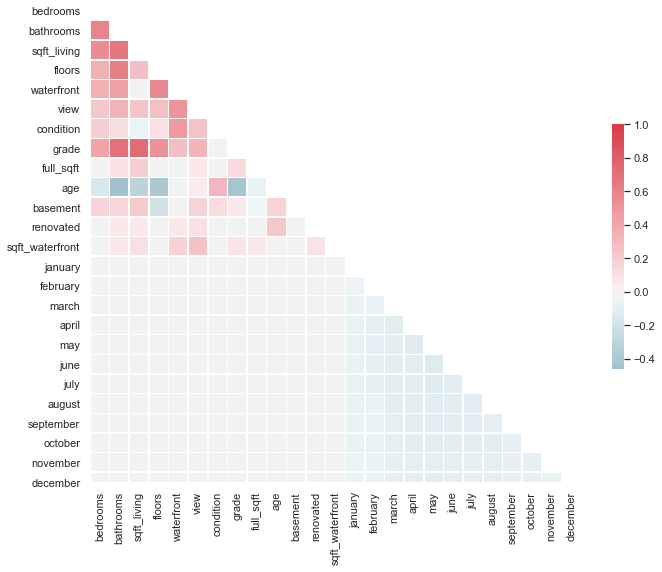

In [109]:
# creating a correlation heatmap, to easily visualize high correlations and refer back to the numerical matrix
sns.set(style="white")
# compute the correlation matrix
corr = x_train_1.corr()
# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig('visualizations/corr_heatmap.png', bbox_inches = "tight", pad_inches=.5)

From the correlation matrix, it looks like the feature with the most correlation issues is `grade`. That feature has two of the highest correlation coefficients.
    
- correlation of .67 with `sqft_living`
- correlation of .69 with `bathrooms'

Let's try dropping `grade` completely for the next model iteration and see if there's any changes.

## Creating Model #2
This model is the same as the first one, but without the `grade` feature.

In [110]:
## fitting the model to the training data:
# setting 'x_train_2' to the features I want to fit in this first model
x_train_2 = x_train[['bedrooms','bathrooms','sqft_living','floors','waterfront','view','condition','full_sqft','age','basement','renovated','sqft_waterfront','january','february','march','april','may','june','july','august','september','october','november','december']]

# instantiate LinearRegression to use
# coefficients are learnt and stored in 'model_2'
model_2 = LinearRegression()
model_2.fit(x_train_2, y_train)

## predicting on the y (price) for train_set
y_pred = model_2.predict(x_train_2)

# get the RMSE for the train set
model_2_rsme = mean_squared_error(y_train, y_pred, squared=False)
model_2_rsme

236433.3380236692

In [111]:
## transforming and .predict on the test_set
x_test_2 = x_test[['bedrooms','bathrooms','sqft_living','floors','waterfront','view','condition','full_sqft','age','basement','renovated','sqft_waterfront','january','february','march','april','may','june','july','august','september','october','november','december']]

testing_model_2 = LinearRegression().fit(x_train_2, y_train)

## predicting on the y (price) for test_set
y_pred_test = testing_model_2.predict(x_test_2)

# get the RMSE for the train set
testing_model_2_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
testing_model_2_rmse

230855.4621840552

In [112]:
print('Model 1 Testing RMSE:' , testing_model_1_rmse)
print('Model 2 Testing RMSE:' , testing_model_2_rmse)

Model 1 Testing RMSE: 214251.9000331857
Model 2 Testing RMSE: 230855.4621840552


So the RMSE got slightly higher. Let's go back to the first model that includes `grade`. In that model, the OLS summary table indicates that `basement` has a p-value of 0.912, so let's drop it and see what happens.


## Creating Model #3
Same as model 1, but without the `basement` feature.


In [113]:
## fitting the model to the training data:
# setting 'x_train_2' to the features I want to fit in this first model
x_train_3 = x_train[['bedrooms','bathrooms','sqft_living','floors','waterfront','view','condition','grade','full_sqft','age','renovated','sqft_waterfront','january','february','march','april','may','june','july','august','september','october','november','december']]

# instantiate LinearRegression to use
# coefficients are learnt and stored in 'model_2'
model_3 = LinearRegression()
model_3.fit(x_train_3, y_train)

## predicting on the y (price) for train_set
y_pred = model_3.predict(x_train_3)

# get the RMSE for the train set
model_3_rsme = mean_squared_error(y_train, y_pred, squared=False)
model_3_rsme

220709.21712664582

In [114]:
## transforming and .predict on the test_set
x_test_3 = x_test[['bedrooms','bathrooms','sqft_living','floors','waterfront','view','condition','grade','full_sqft','age','renovated','sqft_waterfront','january','february','march','april','may','june','july','august','september','october','november','december']]

testing_model_3 = LinearRegression().fit(x_train_3, y_train)

## predicting on the y (price) for test_set
y_pred_test = testing_model_3.predict(x_test_3)

# get the RMSE for the train set
testing_model_3_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
testing_model_3_rmse

214253.74121584598

In [115]:
print('Model 1 Testing RMSE:' , testing_model_1_rmse)
print('Model 3 Testing RMSE:' , testing_model_3_rmse)

Model 1 Testing RMSE: 214251.9000331857
Model 3 Testing RMSE: 214253.74121584598


Even after dropping `basement`, model 1's RMSE actually increases.

## Evaluating the different models in order to determine the best model overall:

In [116]:
# Print the testing RMSE for all models and whether they are overfit or underfit

# Baseline Model
print('Baseline Model RMSE:', dummy_rmse)

# Model 1
print('Training RMSE for Model 1:', model_1_rsme)
print('Testing RMSE for Model 1:', testing_model_1_rmse)
if model_1_rsme < testing_model_1_rmse:
    print('Model 1 is overfit')
elif model_1_rsme > testing_model_1_rmse:
    print('Model 1 is underfit')

# Model 2
print('Training RMSE for Model 2:', model_2_rsme)
print('Testing RMSE for Model 2:', testing_model_2_rmse)
if model_2_rsme < testing_model_2_rmse:
    print('Model 2 is overfit')
elif model_2_rsme > testing_model_2_rmse:
    print('Model 2 is underfit')

# Model 3
print('Training RMSE for Model 3:', model_3_rsme)
print('Testing RMSE for Model 3:', testing_model_3_rmse)
if model_3_rsme < testing_model_3_rmse:
    print('Model 3 is overfit')
elif model_3_rsme > testing_model_3_rmse:
    print('Model 3 is underfit')

Baseline Model RMSE: 375414.5547329206
Training RMSE for Model 1: 220709.11965382707
Testing RMSE for Model 1: 214251.9000331857
Model 1 is underfit
Training RMSE for Model 2: 236433.3380236692
Testing RMSE for Model 2: 230855.4621840552
Model 2 is underfit
Training RMSE for Model 3: 220709.21712664582
Testing RMSE for Model 3: 214253.74121584598
Model 3 is underfit


Let's look at the testing RMSE for all of these models. Out of all three, model 1 performed the best on the testing data! So let's fit that original model on our whole `housing` dataset.

## Refitting the final model to the entire `housing` dataset:

In [117]:
final_model = LinearRegression()

#fit the linear regression to the data
final_model = final_model.fit(housing[['bedrooms','bathrooms','sqft_living','floors','waterfront','view','condition','grade','full_sqft','age','basement','renovated','sqft_waterfront','january','february','march','april','may','june','july','august','september','october','november','december']], housing['price'])

In [118]:
final_model.coef_

array([-4.31852778e+04,  4.69046465e+04,  1.78713168e+02,  2.29883393e+04,
        5.43049606e+05,  4.43370431e+04,  1.98989935e+04,  1.23844543e+05,
       -2.81892153e-01,  3.60180851e+03,  1.38155212e+03,  1.15704846e+04,
        1.58883949e+00,  3.40185301e+07,  3.40217175e+07,  3.40508965e+07,
        3.40568765e+07,  3.40299325e+07,  3.40256026e+07,  3.40158423e+07,
        3.40262614e+07,  3.40106715e+07,  3.40219516e+07,  3.40185830e+07,
        3.40141533e+07])

Saving final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/